# Selection Criteria
For our project we will have to have crteria or a model/function which can distinguish between signal and background event with some probability. Where evidently we want a model that is more likely to remove only background and no signal. There are likely some physical motivations behind this. We can find this out by for example looking at how quickly in terms of time or distance a certain decay should happen and narrowing down. We will approach selection with two methods. The first a `quick and dirty' approach from just looking at different variables plotted against eachother and making reasonably safe cut. Then we will go onto using a neural network or machine learning algorithm to fine tune our cuts and make them as effective as possible.

## Parameter Cut Approach
The easiest way to make some quick cuts is to plot different variables against one another and see if anything can be easily distinguished. For example we could plot the $p_T$ of the muon versus that of the electron and we might find an discernable difference. We approach this firstly by just considering the momenta, polar angle and $\chi^2$ of the 2 leptons.

In [3]:
import pandas as pd
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fName="/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/100FilesCheck/job185-CombDVntuple-15314000-MC2016MD_100F-pKmue-MC.root"

In [4]:
features = ['L1_PX', 'L1_PY', 'L1_PZ', 'L2_PX', 'L2_PY', 'L2_PZ', 'L1_PT', 'L2_PT', 'Lb_BKGCAT']

# Try using impact parameters and other variables see if any other easy cuts can be made. 

In [ ]:
def get_specific_features(features):
    with up.open(fName + ":DTT1520me/DecayTree") as f:
        df = f.arrays(features, library="pd")
    df['L1_P'] = np.sqrt(df['L1_PX']**2 + df['L1_PY']**2 + df['L1_PZ']**2)
    df['L2_P'] = np.sqrt(df['L2_PX']**2 + df['L2_PY']**2 + df['L2_PZ']**2)
    df['L1_theta'] = np.arcsin(df['L1_PT']/df['L1_P'])
    df['L2_theta'] = np.arcsin(df['L2_PT']/df['L2_P'])
    df['class'] = np.where(df['Lb_BKGCAT'] == 10, 1, 0)
    df.drop('Lb_BKGCAT', axis=1, inplace=True)
    return df

In [5]:
df = get_specific_features(['L1_PX', 'L1_PY', 'L1_PZ', 'L2_PX', 'L2_PY', 'L2_PZ', 'L1_PT', 'L2_PT', 'Lb_BKGCAT'])

df.head()

L1_PX   L1_PY     L1_PZ    L2_PX   L2_PY     L2_PZ        L1_PT  \
0  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
1  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
2  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
3  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
4  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   

         L2_PT          L1_P          L2_P  L1_theta  L2_theta  class  
0  1031.105163  11297.693849  10710.517954  0.198427  0.096420      0  
1  1010.616156  11297.693849   8394.575666  0.198427  0.120682      1  
2  1010.616156  11297.693849   8394.575666  0.198427  0.120682      0  
3  1031.105163  11297.693849  10710.517954  0.198427  0.096420      0  
4  1031.105163  11297.693849  10710.517954  0.198427  0.096420      0

Now we have a healthy amount of variables and have categorised each event so we can colour the points to make distinguishing things easier when plotted. We now employ Seaborn's useful utilty which generates plots between every variable in a set.

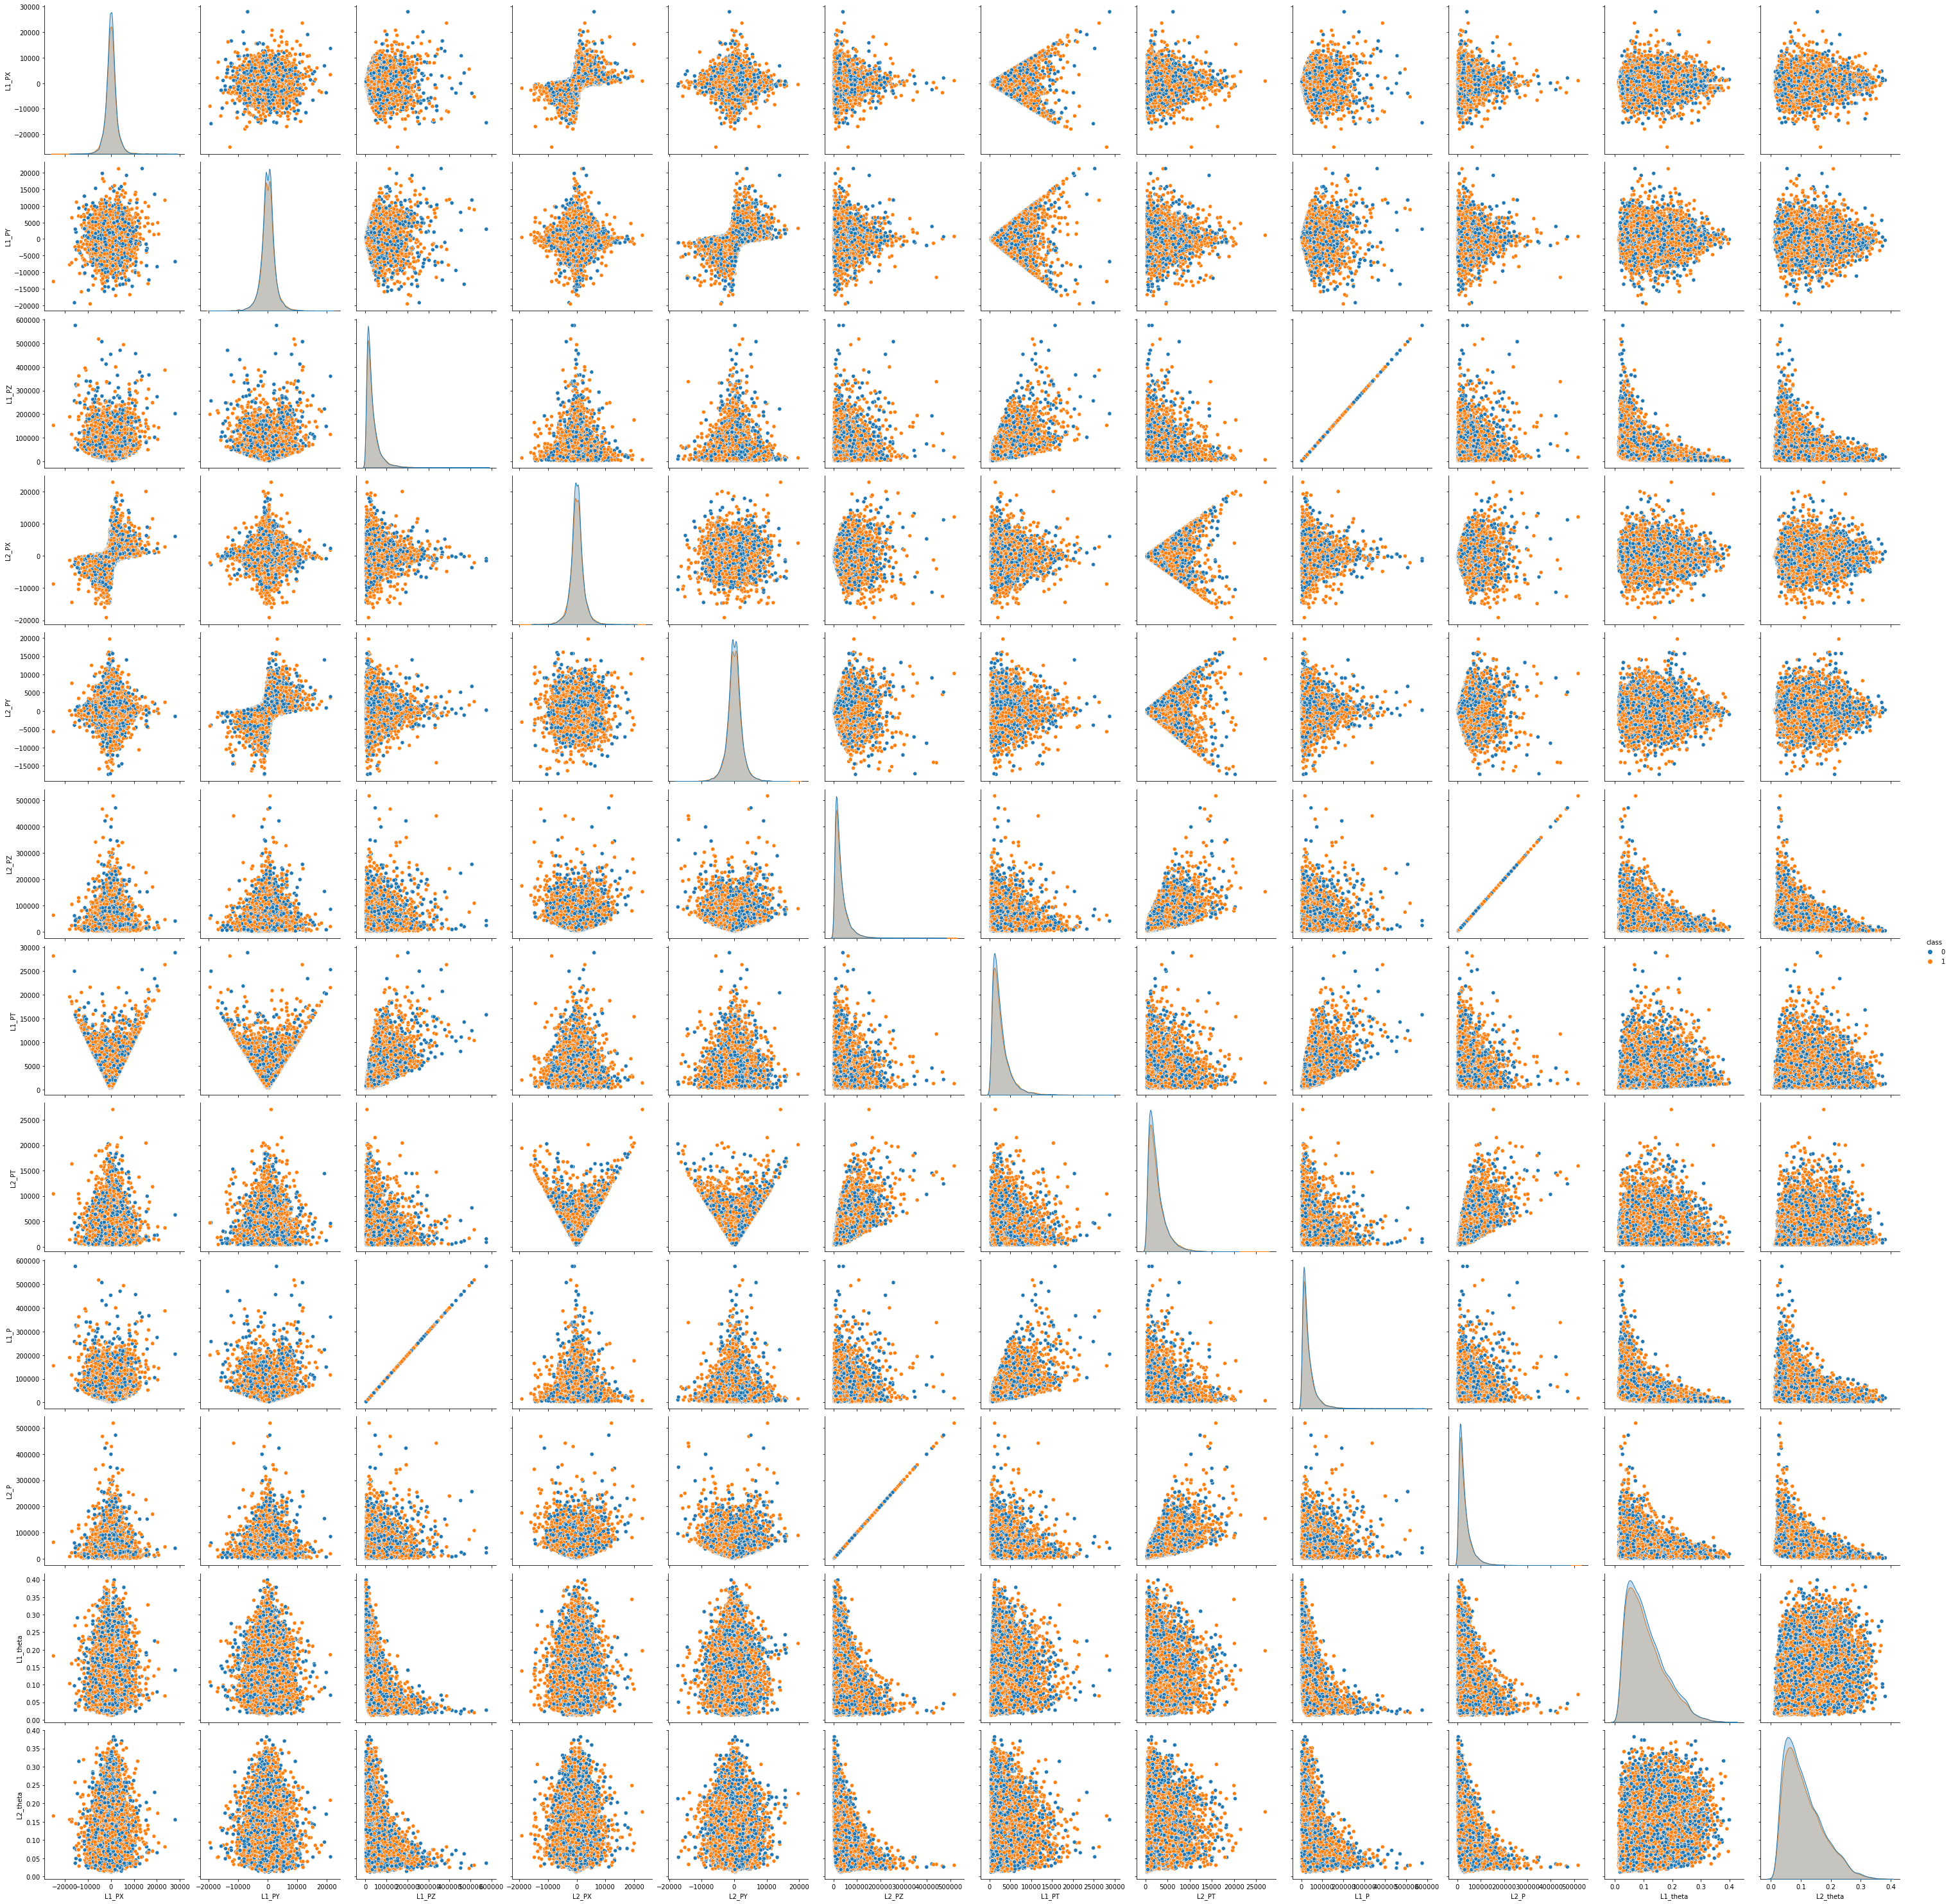

In [6]:
sns.pairplot(df, vars=df.columns[:-1], hue='class', height=3.5)

# NEURAL NETWORK STUFF STARTS HERE

In [7]:
import pandas as pd
import numpy as np
from sklearn import metrics
import uproot as up
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

In [8]:
fName="/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/100FilesCheck/job185-CombDVntuple-15314000-MC2016MD_100F-pKmue-MC.root"

In [9]:
with up.open(fName + ":DTT1520me/DecayTree") as f:
    features = ['L1_PX', 'L1_PY', 'L1_PZ', 'L2_PX', 'L2_PY', 'L2_PZ', 'L1_PT', 'L2_PT', 'p_PX', 'p_PY', 'p_PZ',
                'p_PT', 'Lb_TRUEID', 'Lb_ID']
    df = f.arrays(features, library="pd")

It is likely we need far more features to accurately train any neural network or ML algorithm. However, I have not added any yet because I do not have a clue what most of the variable names mean. Also note that the PID cannot be inlcuded as a feature since this is not realistic and the model will obviously learn immedeately to select via PID.

## Getting the Data Ready & Feature Engineering

In [10]:
df['category'] = np.where(df['Lb_TRUEID'] == df['Lb_ID'], 1, 0)
# We have defined '1' as a signal event and '0' as a background event, the model needs this kind of binary 
# classification column to train on, remove the PID colunns as well!
df.drop(labels=['Lb_TRUEID', 'Lb_ID'], axis='columns', inplace=True)
# And drop duplicate data
df.drop_duplicates(keep='first', inplace=True)
df.head()

L1_PX   L1_PY     L1_PZ    L2_PX   L2_PY     L2_PZ        L1_PT  \
0  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
1  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
2  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
3  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
4  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   

         L2_PT     p_PX    p_PY      p_PZ         p_PT  category  
0  1031.105163  -876.76  502.63   8333.52  1010.616156         1  
1  1010.616156 -1030.59  -32.59  10660.77  1031.105163         1  
2  1010.616156    58.61 -311.02   7873.21   316.494190         0  
3  1031.105163    58.61 -311.02   7873.21   316.494190         0  
4  1031.105163  -810.04  229.96   5628.81   842.048932         0

In [11]:
# Now engineer some more features that could be useful - the obvious being the angle relative to beam axis and |p|
df['L1_P'] = np.sqrt(df['L1_PX']**2 + df['L1_PY']**2 + df['L1_PZ']**2)
df['L2_P'] = np.sqrt(df['L2_PX']**2 + df['L2_PY']**2 + df['L2_PZ']**2)
df['p_P'] = np.sqrt(df['p_PX']**2 + df['p_PY']**2 + df['p_PZ']**2)

df['L1_Angle'] = np.arcsin(df['L1_PT']/df['L1_P'])
df['L2_Angle'] = np.arcsin(df['L2_PT']/df['L2_P'])
df['p_Angle'] = np.arcsin(df['p_PT']/df['p_P'])

df.head()

L1_PX   L1_PY     L1_PZ    L2_PX   L2_PY     L2_PZ        L1_PT  \
0  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
1  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
2  2191.14  398.49  11076.01  -876.76  502.63   8333.52  2227.080775   
3  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   
4  2191.14  398.49  11076.01 -1030.59  -32.59  10660.77  2227.080775   

         L2_PT     p_PX    p_PY      p_PZ         p_PT  category  \
0  1031.105163  -876.76  502.63   8333.52  1010.616156         1   
1  1010.616156 -1030.59  -32.59  10660.77  1031.105163         1   
2  1010.616156    58.61 -311.02   7873.21   316.494190         0   
3  1031.105163    58.61 -311.02   7873.21   316.494190         0   
4  1031.105163  -810.04  229.96   5628.81   842.048932         0   

           L1_P          L2_P           p_P  L1_Angle  L2_Angle   p_Angle  
0  11297.693849  10710.517954   8394.575666  0.198427  0.096420  0.120682  
1  11297.693849   8394.575666  10710.517954  0.198427  0.120682  0.096420  
2  11297.693849   8394.575666   7879.568787  0.198427  0.120682  0.040177  
3  11297.693849  10710.517954   7879.568787  0.198427  0.096420  0.040177  
4  11297.693849  10710.517954   5691.445196  0.198427  0.096420  0.148495

## Creating a Model and Training
The next step is now to define the model and the problem. This is a binary classification problem. We want the model to classify each event, given some set of features whether the event is a signal or background event. We begin by using a - albeit simple - dense connected neural network.

In [12]:
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True)
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('category', axis=1)
X_valid = df_valid.drop('category', axis=1)
y_train = df_train['category']
y_valid = df_valid['category']

X_train.head()

L1_PX     L1_PY     L1_PZ     L2_PX     L2_PY     L2_PZ     L1_PT  \
15758  0.379824  0.461493  0.061404  0.449725  0.437740  0.026516  0.018769   
28284  0.330364  0.397278  0.254631  0.430449  0.489715  0.020213  0.140484   
10735  0.388833  0.499570  0.014910  0.472100  0.486365  0.028095  0.016581   
282    0.390901  0.465449  0.001347  0.449684  0.425807  0.051489  0.007915   
27044  0.388672  0.469314  0.019749  0.446115  0.564473  0.162680  0.002642   

          L2_PT      p_PX      p_PY      p_PZ      p_PT      L1_P      L2_P  \
15758  0.057565  0.492923  0.517705  0.015903  0.017181  0.061095  0.026602   
28284  0.026469  0.462261  0.486431  0.080741  0.063186  0.254405  0.020163   
10735  0.016404  0.605368  0.492507  0.095003  0.189997  0.014637  0.027990   
282    0.071761  0.504206  0.534579  0.098393  0.037145  0.001103  0.051515   
27044  0.069468  0.476982  0.494337  0.059029  0.045218  0.019436  0.162546   

            p_P  L1_Angle  L2_Angle   p_Angle  
15758  0.015730  0.027681  0.304935  0.208826  
28284  0.080607  0.043108  0.209211  0.126020  
10735  0.095618  0.154350  0.101925  0.340842  
282    0.098162  0.378602  0.186620  0.051010  
27044  0.058869  0.045321  0.037598  0.127582

2021-11-09 14:11:24.789027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 14:11:24.803142: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-09 14:11:25.176240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-09 14:11:25.199170: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/100
46/46 [==============================] - 2s 12ms/step - loss: 0.6933 - binary_accuracy: 0.5013 - val_loss: 0.6879 - val_binary_accuracy: 0.5802
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6852 - binary_accuracy: 0.5720 - val_loss: 0.6810 - val_binary_accuracy: 0.5798
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 0.6807 - binary_accuracy: 0.5723 - val_loss: 0.6773 - val_binary_accuracy: 0.5798
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.6783 - binary_accuracy: 0.5723 - val_loss: 0.6750 - val_binary_accuracy: 0.5798
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.6755 - binary_accuracy: 0.5723 - val_loss: 0.6717 - val_binary_accuracy: 0.5798
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.6717 - binary_accuracy: 0.5723 - val_loss: 0.6672 - val_binary_accuracy: 0.5798
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - lo

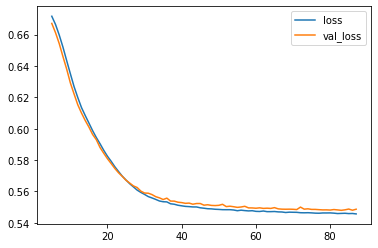

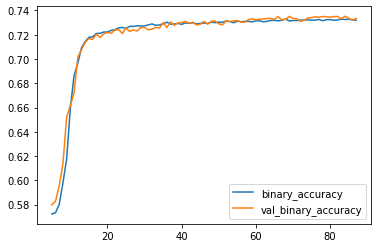

In [13]:
# A simple model made of 3 layers each with 8 nodes apart from the last layer. The sigmoid activation function
# has to be used when doing a binary classification problem
model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[18]),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['binary_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))